In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
import copy
import torch
from torch import nn
from model import ET_Rnn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device='cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def fit(self, train_loader, test_loader=None, epoch=1, early_stop=-1, eval_type='RMSE', scaler=None):
        history = {
            'train': [], 
            'test': []
        }
        
        best_eval = 9e9
        early_cnt = 0
        best_model_params = copy.deepcopy(self.model.state_dict())
        
        for ep in tqdm(range(epoch)):
            print('Epoch:{}'.format(ep+1))
            
            for batch in train_loader:
                self.model.train()
                self.optimizer.zero_grad()
                
                x_dense, x_sparse, y = [b.to(self.device) for b in batch]
                
                output = self.model(x_dense, x_sparse)
                loss = self.criterion(output, y)

                loss.backward()
                self.optimizer.step()
                
            train_result, _, _ = self.evaluate(train_loader, scaler)
            history['train'].append(train_result)
            print('\ttrain\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
            
            if test_loader:
                test_result, _, _ = self.evaluate(test_loader, scaler)
                history['test'].append(test_result)
                print('\ttest\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result.items()]))

                if test_result[eval_type] < best_eval:
                    early_cnt = 0
                    best_eval = test_result[eval_type]
                    best_model_params = copy.deepcopy(self.model.state_dict())
                    print('\tbetter!')

                elif early_stop > 0:
                    early_cnt += 1

            if early_cnt >= early_stop:
                break
        
        self.model.load_state_dict(best_model_params)
        
        return history
        
    def evaluate(self, loader, scaler=None):
        true_list = []
        pred_list = []
        
        self.model.eval()
        for batch in loader:
            x_dense, x_sparse, y = [b.to(self.device) for b in batch]
            output = self.model(x_dense, x_sparse)
            
            true_list.append(y.cpu().detach().numpy())
            pred_list.append(output.cpu().detach().numpy())
        
        true_list = np.concatenate(true_list, axis=0)
        pred_list = np.concatenate(pred_list, axis=0)
        
        true_list = np.expm1(scaler.inverse_transform(true_list) if scaler else true_list)
        pred_list = np.expm1(scaler.inverse_transform(pred_list) if scaler else pred_list)
        
        result = {
            'RMSE': mean_squared_error(true_list, pred_list, squared=False), 
            'MAE(mean)': mean_absolute_error(true_list, pred_list), 
            'MAE(median)': median_absolute_error(true_list, pred_list)
        }
        
        return result, true_list, pred_list

In [4]:
sample_path = './data/sample_50k'

x_train = np.load(os.path.join(sample_path, 'ETRNN', 'x_train.npy'))
x_test = np.load(os.path.join(sample_path, 'ETRNN', 'x_test.npy'))
y_train = np.load(os.path.join(sample_path, 'ETRNN', 'y_train.npy'))
y_test = np.load(os.path.join(sample_path, 'ETRNN', 'y_test.npy'))

chid_mapper = np.load(os.path.join(sample_path, 'sample_idx_map.npy'), allow_pickle=True).item()
feat_mapper = np.load(os.path.join(sample_path, 'ETRNN', 'feature_map.npy'), allow_pickle=True).item()

category_cols = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity', 'tcode']
numeric_cols = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam']

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, len(chid_mapper), [(k, len(v)) for k, v in feat_mapper.items()])

(450000, 20, 10) (100000, 20, 10) (450000, 1) (100000, 1) 50000 [('bnsfg', 2), ('iterm', 17), ('mcc', 502), ('scity', 11242), ('tcode', 6)]


In [5]:
sparse_feat = category_cols
dense_feat = numeric_cols

In [6]:
USE_CHID = True
idx_start = 1-int(USE_CHID)

chid_embed_dim = 64
feat_embed_dim = 4

dense_dims = len(dense_feat) # number of dense feature
feat_dims = np.array([len(chid_mapper)] + [len(v) for v in feat_mapper.values()])+1 # 0 is padding index, so add 1 dims
embed_dims = [chid_embed_dim]+[feat_embed_dim]*len(feat_mapper) # dims of chid and other sparse feature

sparse_dims = [(fd, ed) for fd, ed in zip(feat_dims[idx_start:], embed_dims[idx_start:])]

dense_dims, sparse_dims

(4, [(50001, 64), (3, 4), (18, 4), (503, 4), (11243, 4), (7, 4)])

In [7]:
# x_data
x_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_dense = x_train[:, :, len(sparse_feat):] # split dense feature
x_train_sparse = x_train[:, :, idx_start:len(sparse_feat)] # split sparse feature

x_train_dense = np.log1p(x_train_dense - x_train_dense.min(axis=0))
x_train_dense = x_scaler.fit_transform(x_train_dense.reshape(-1, x_train_dense.shape[-1])).reshape(x_train_dense.shape)

x_test_dense = x_test[:, :, len(sparse_feat):]
x_test_sparse = x_test[:, :, idx_start:len(sparse_feat)]

x_test_dense = np.log1p(x_test_dense - x_test_dense.min(axis=0))
x_test_dense = x_scaler.transform(x_test_dense.reshape(-1, x_test_dense.shape[-1])).reshape(x_test_dense.shape)

In [8]:
# y_data
USE_YMINMAX = False
y_scaler = None

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

if USE_YMINMAX:
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

In [9]:
print(x_train_dense.shape, x_train_sparse.shape, y_train.shape)
print(x_test_dense.shape, x_test_sparse.shape, y_test.shape)

(450000, 20, 4) (450000, 20, 6) (450000, 1)
(100000, 20, 4) (100000, 20, 6) (100000, 1)


In [10]:
batch_size = 2048

train_dataset = TensorDataset(torch.FloatTensor(x_train_dense), torch.LongTensor(x_train_sparse), 
                              torch.FloatTensor(y_train))
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)

test_dataset = TensorDataset(torch.FloatTensor(x_test_dense), torch.LongTensor(x_test_sparse), 
                             torch.FloatTensor(y_test))
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=8)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ET_Rnn(dense_dims, sparse_dims, hidden_dims=64, out_dim=1, n_layers=1, 
               use_chid=USE_CHID,  cell='GRU', bi=False, dropout=0.1, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

ET_Rnn(
  (embedding_list): ModuleList(
    (0): Embedding(50001, 64, padding_idx=0)
    (1): Embedding(3, 4, padding_idx=0)
    (2): Embedding(18, 4, padding_idx=0)
    (3): Embedding(503, 4, padding_idx=0)
    (4): Embedding(11243, 4, padding_idx=0)
    (5): Embedding(7, 4, padding_idx=0)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (user_layer): Linear(in_features=64, out_features=64, bias=True)
  (rnn): GRU(88, 64, batch_first=True)
  (out_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
USE_PRETRAINED = False
if USE_CHID and USE_PRETRAINED:
    embed = np.load(os.path.join(sample_path, 'embedding/node2vec_50k_0112.npy'), allow_pickle=True)
    embed = torch.from_numpy(embed[:50000])
    model.embedding_list[0].weight.data[1:].copy_(embed)

In [13]:
TRAIN_TYPE = [('RMSE', nn.MSELoss()), 
              ('MAE(mean)', nn.L1Loss())]
eval_type, criterion = TRAIN_TYPE[0]

t0 = time()
trainer = Trainer(model, criterion, optimizer, device)
history = trainer.fit(train_loader, test_loader, epoch=200, early_stop=10, eval_type=eval_type, scaler=y_scaler)
t1 = time()

print('cost: {:.2f}'.format(t1 - t0))

Epoch:1
	train	RMSE:397821.03 MAE(mean):62903.80 MAE(median):9589.73
	test	RMSE:423196.19 MAE(mean):70638.39 MAE(median):10327.43
	better!
Epoch:2
	train	RMSE:394857.31 MAE(mean):56826.42 MAE(median):10518.48
	test	RMSE:419842.44 MAE(mean):63693.64 MAE(median):11266.42
	better!
Epoch:3
	train	RMSE:393431.44 MAE(mean):55085.52 MAE(median):10621.01
	test	RMSE:418143.06 MAE(mean):61579.71 MAE(median):11182.07
	better!
Epoch:4
	train	RMSE:392504.28 MAE(mean):54200.51 MAE(median):10430.98
	test	RMSE:417020.78 MAE(mean):60600.90 MAE(median):11203.23
	better!
Epoch:5
	train	RMSE:392233.41 MAE(mean):53714.15 MAE(median):9483.93
	test	RMSE:416681.12 MAE(mean):60185.89 MAE(median):10427.49
	better!
Epoch:6
	train	RMSE:391368.25 MAE(mean):52875.83 MAE(median):9499.59
	test	RMSE:415762.44 MAE(mean):59560.87 MAE(median):10571.29
	better!
Epoch:7
	train	RMSE:389847.31 MAE(mean):52466.18 MAE(median):10937.14
	test	RMSE:414233.28 MAE(mean):59693.71 MAE(median):12598.38
	better!
Epoch:8
	train	RMSE:390

	train	RMSE:367551.62 MAE(mean):42446.86 MAE(median):6746.71
	test	RMSE:405606.16 MAE(mean):59312.88 MAE(median):11513.06
Epoch:63
	train	RMSE:359640.72 MAE(mean):41807.16 MAE(median):7658.09
	test	RMSE:403026.66 MAE(mean):61903.36 MAE(median):13173.87
Epoch:64
	train	RMSE:363754.53 MAE(mean):41331.23 MAE(median):6609.04
	test	RMSE:404053.25 MAE(mean):59867.09 MAE(median):11900.82
Epoch:65
	train	RMSE:358934.09 MAE(mean):41088.54 MAE(median):6886.09
	test	RMSE:402693.16 MAE(mean):60810.21 MAE(median):12360.12
Epoch:66
	train	RMSE:361958.06 MAE(mean):41178.61 MAE(median):6461.10
	test	RMSE:404058.62 MAE(mean):60298.25 MAE(median):11847.09
Epoch:67
	train	RMSE:362004.28 MAE(mean):40813.87 MAE(median):6687.08
	test	RMSE:403664.09 MAE(mean):60871.40 MAE(median):12384.50
Epoch:68
	train	RMSE:358731.06 MAE(mean):40916.94 MAE(median):6928.24
	test	RMSE:403081.12 MAE(mean):61568.89 MAE(median):12836.19
Epoch:69
	train	RMSE:355922.91 MAE(mean):40708.33 MAE(median):7092.21
	test	RMSE:402458.81 M

In [14]:
train_result, train_true_list, train_pred_list = trainer.evaluate(train_loader, scaler=y_scaler)
test_result, test_true_list, test_pred_list = trainer.evaluate(test_loader, scaler=y_scaler)

print('train\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
print('test\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result.items()]))

train	RMSE:355922.94 MAE(mean):40708.32 MAE(median):7092.21
test	RMSE:402458.81 MAE(mean):62389.84 MAE(median):13006.31


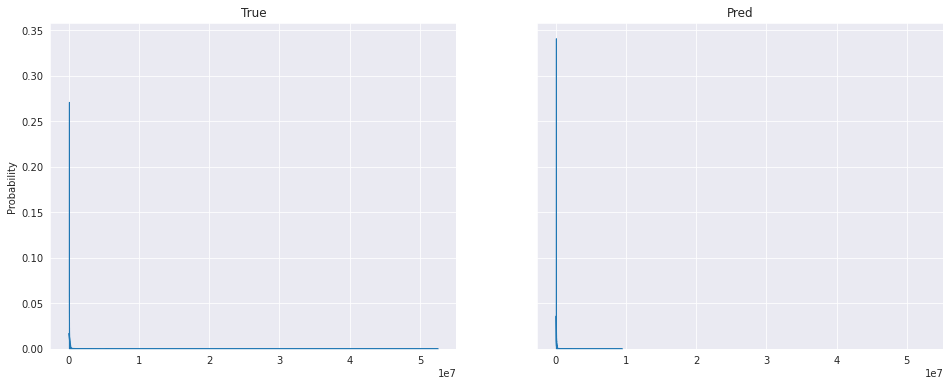

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)
    fig.suptitle('')
    
    sns.histplot(ax=axes[0], x=test_true_list.flatten(), kde=True, element='step', stat='probability')
    sns.histplot(ax=axes[1], x=test_pred_list.flatten(), kde=True, element='step', stat='probability')
    axes[0].set_title('True')
    axes[1].set_title('Pred')
    plt.show()

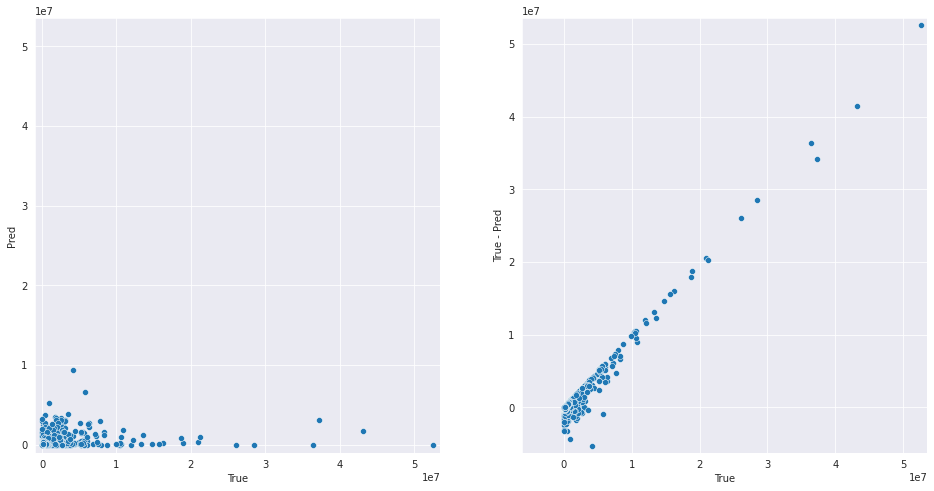

In [16]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
    fig.suptitle('')

    sns.scatterplot(ax=axes[0], x=test_true_list.flatten(), y=test_pred_list.flatten())
    xylim = (np.min([test_true_list, test_pred_list])-.1e7, np.max([test_true_list, test_pred_list])+.1e7)
    axes[0].set(xlabel='True', ylabel='Pred', xlim=xylim, ylim=xylim)
    
    sns.scatterplot(ax=axes[1], x=test_true_list.flatten(), y=test_true_list.flatten()-test_pred_list.flatten())
    xylim = (np.min([test_true_list, test_true_list-test_pred_list])-.1e7, np.max([test_true_list, test_true_list-test_pred_list])+.1e7)
    axes[1].set(xlabel='True', ylabel='True - Pred', xlim=xylim, ylim=xylim)
    plt.show()

In [17]:
df_out = pd.DataFrame({
    'chid': x_test[:, -1, 0].astype(np.int64), 
    'true': test_true_list.flatten(),
    'pred': test_pred_list.flatten()
})

df_out.head(2)

,chid,true,pred
0,1,41007.996094,25.493441
1,1,407783.937500,23199.287109


In [18]:
#df_out.to_csv('result/etRNN_random.csv', index=False, encoding='utf-8')